# Toy example optimizaing by using all data
In this notebook all model paremeters but the variatioanl distribution are assumed known, so we evaluate how well the model infers the latent component and activation.  Optimization consists on maximazing the ELBO by using all data at once.

In [1]:
%matplotlib inline
import sys 
sys.path.append('../../../../')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpflow, gpitch
reload(gpitch)
from gpitch.amtgp import logistic
from scipy.fftpack import fft, ifft, ifftshift
from scipy import signal
from gpitch import myplots
import time 
np.random.seed(20)
plt.rcParams['figure.figsize'] = (16, 3)  # set plot size

## Generate synthetic data

In [2]:
# define hyperparameters for data generation
Nc = 5  # number of "harmoncics"
f0 = 220.0 # ideal natural frequency
N, fs = 1600, 16e3  # number of data points and sampling frequency
noise_var = 1e-3  # variance noise
x = np.linspace(0., (N-1.)/fs, N).reshape(-1, 1)  # time vector

Define kernels for component and activation

In [3]:
var = np.random.rand(Nc)  # variances
var_scale = 1./ (4.*np.sum(var)) #rescale sigma (overall var = 0.25)
var *= var_scale  
leng = 0.75  # lengthscale
freq = f0*np.asarray(range(1, Nc+ 1))
kern_act = gpflow.kernels.Matern32(input_dim=1, lengthscales=0.05, variance=10.)
kern_com = gpitch.kernels.MaternSpecMix(lengthscales=leng, variances=var, frequencies=freq,
                                        Nc=Nc)

Compute covariance matrices, and sample one component and activation function

In [4]:
sample = True
if sample:
    Kcom = kern_com.compute_K_symm(x)  # cov matrices
    Kact = kern_act.compute_K_symm(x)
    com = np.random.multivariate_normal(np.zeros((N)), Kcom, 1).reshape(-1, 1)  # sample com
    com /= np.max(np.abs(com))
    com -= com.mean()
    g = np.random.multivariate_normal(np.zeros((N)), Kact, 1).reshape(-1, 1)  # sample act
    act = logistic(g)
    act /= np.max(act)
    y = act*com + np.sqrt(noise_var)*np.random.randn(N,1)  # generate noisy data

Plot data, activation and component

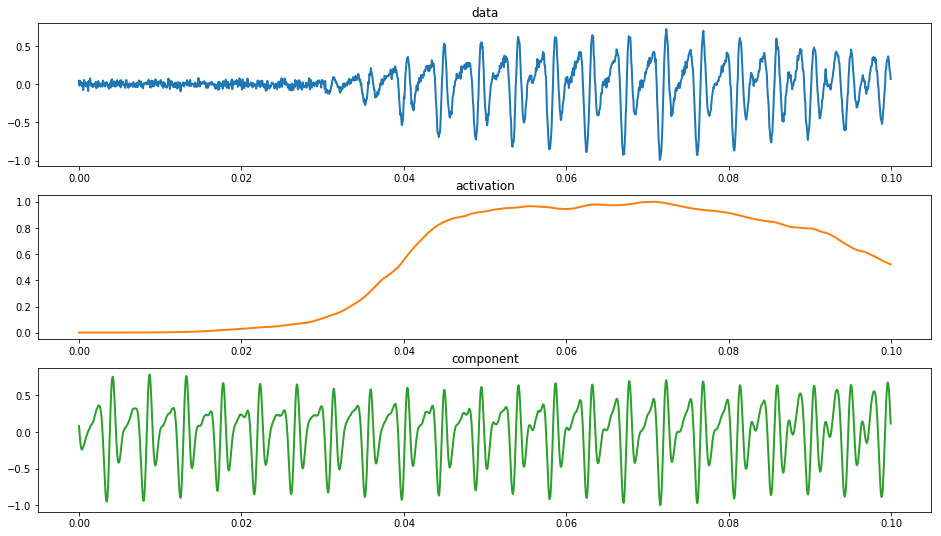

In [5]:
plt.figure(figsize=(16, 9))
plt.subplot(3,1,1), plt.title('data')
plt.plot(x, y, 'C0', lw=2 )
plt.subplot(3,1,2), plt.title('activation')
plt.plot(x, act, 'C1', lw=2)
plt.subplot(3,1,3), plt.title('component')
plt.plot(x, com, 'C2', lw=2)

## Define model


Define kernels for component and activation, and generate model object ("sigmoid model")

In [6]:
dec = 40  # decimation factor
z = np.vstack((x[::dec].copy(), x[-1].copy()))
m = gpitch.modgp.ModGP(x=x, y=y, z=z, kern_com=kern_com, kern_act=kern_act)  # sigmoid model
m.likelihood.variance = noise_var
m.likelihood.variance.fixed = True
m.z.fixed = True
m.kern_com.fixed = True
m.kern_act.fixed = True

Set all parameters free to optimize, but variances of component

## Inference


In [7]:
m.optimize(disp=1, maxiter=1000)

      fun: -2712.7554485694177
 hess_inv: <3444x3444 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.00754315, -2.22518312, -1.24883459, ..., -0.01171179,
       -0.00728251,  0.12610909])
  message: 'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 1042
      nit: 1001
   status: 1
  success: False
        x: array([-2.18261565,  0.00743781,  0.10384258, ..., -0.01938421,
        0.01441737, -0.31339741])

## Results
Compute prediction for component and activation, plot results

/home/pa/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


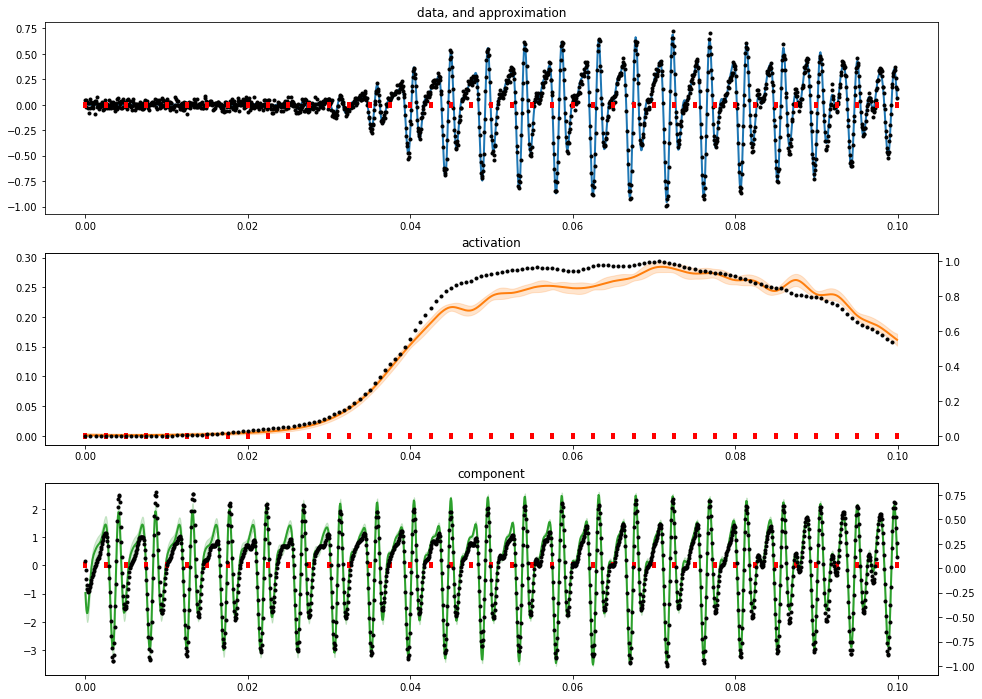

In [8]:
reload(myplots)
mean_f, var_f, mean_g, var_g, x_plot  = m.predict_all(x)
myplots.plot_results(mean_f, var_f, mean_g, var_g, x_plot, y, z)
plt.subplot(3, 1, 2)
plt.twinx()
plt.plot(x_plot[::10], act[::10], '.k')
plt.subplot(3, 1, 3)
plt.twinx()
plt.plot(x_plot, com, '.k')